In [1]:
from pathlib import Path 
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, SkyOffsetFrame

import matplotlib.pyplot as plt 
import astropy.units as u
import pandas as pd
import numpy as np 
import pickle 

fits_file = Path.home() / "mulab/main/assets/jwst_init_NRCB.fits"
catalog   = Table.read(fits_file) 

In [2]:
# extracting ra/dec 
with fits.open(fits_file) as hdul:
    hdr = hdul[1].header  
    ra0  = hdr["RA_0_REF"]  * u.deg
    dec0 = hdr["DEC_0_REF"] * u.deg

# origin ~ sag A*
origin = SkyCoord(ra0, dec0, frame="icrs")

xoff = catalog["x_ave_wcs"] * u.arcsec
yoff = catalog["y_ave_wcs"] * u.arcsec

sky  = SkyCoord(xoff, yoff, frame=SkyOffsetFrame(origin=origin)).icrs
catalog["RA_ICRS_deg"]  = sky.ra.deg
catalog["DEC_ICRS_deg"] = sky.dec.deg

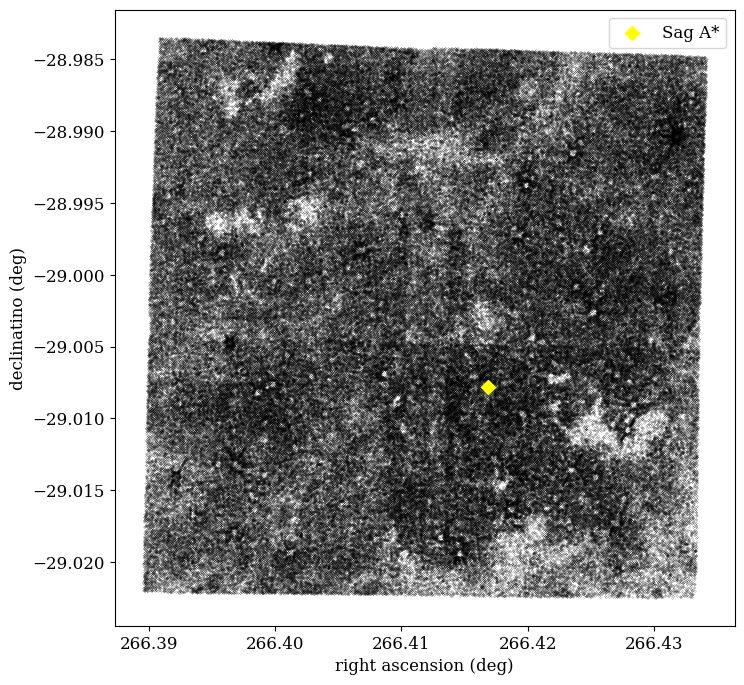

In [4]:
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'serif'

x = catalog["RA_ICRS_deg"] 
y = catalog["DEC_ICRS_deg"] 

fig, axis = plt.subplots(1, 1, figsize=(8, 8)) 
plt.scatter(
    catalog["RA_ICRS_deg"], 
    catalog["DEC_ICRS_deg"], 
    s=0.02, 
    c='k', 
)

plt.scatter(266.41683, -29.00781, marker='D', c='yellow', s=50, label='Sag A*')

plt.xlabel("right ascension (deg)") 
plt.ylabel("declinatino (deg)")
plt.legend()

In [5]:
assets = Path.home() / "mulab/main/assets/" 
NRCB1  = assets / "NRCB1.pickle"
NRCB2  = assets / "NRCB2.pickle"
NRCB3  = assets / "NRCB3.pickle"
NRCB4  = assets / "NRCB4.pickle"


with open(NRCB1, "rb") as f: nrcb1 = pickle.load(f)
with open(NRCB2, "rb") as f: nrcb2 = pickle.load(f)
with open(NRCB3, "rb") as f: nrcb3 = pickle.load(f)
with open(NRCB4, "rb") as f: nrcb4 = pickle.load(f)

In [6]:
def add_radec(
    df: pd.DataFrame,
    fits_file: Path,
    xcol: str = "x_ave_wcs",
    ycol: str = "y_ave_wcs",
    ra_col: str = "ra",
    dec_col: str = "dec"
) -> pd.DataFrame:
    
    with fits.open(fits_file) as hdul:
        hdr = hdul[1].header
        ra0_deg = float(hdr["RA_0_REF"])
        dec0_deg = float(hdr["DEC_0_REF"])

    # sag A*
    origin = SkyCoord(ra0_deg * u.deg, dec0_deg * u.deg, frame="icrs")

    
    xoff = df[xcol].to_numpy(dtype=float)
    yoff = df[ycol].to_numpy(dtype=float)
    m = np.isfinite(xoff) & np.isfinite(yoff)

    ra = np.full(xoff.shape, np.nan, dtype=float)
    dec = np.full(yoff.shape, np.nan, dtype=float)

    if np.any(m):
        sky = SkyCoord(xoff[m] * u.arcsec,
                       yoff[m] * u.arcsec,
                       frame=SkyOffsetFrame(origin=origin)).icrs
        ra[m] = sky.ra.deg
        dec[m] = sky.dec.deg

    df[ra_col]  = ra  
    df[dec_col] = dec 
    return df

In [7]:
nrcb1_ = add_radec(nrcb1, fits_file)
nrcb2_ = add_radec(nrcb2, fits_file) 
nrcb3_ = add_radec(nrcb3, fits_file)
nrcb4_ = add_radec(nrcb4, fits_file) 

Text(0, 0.5, 'declination (deg)')

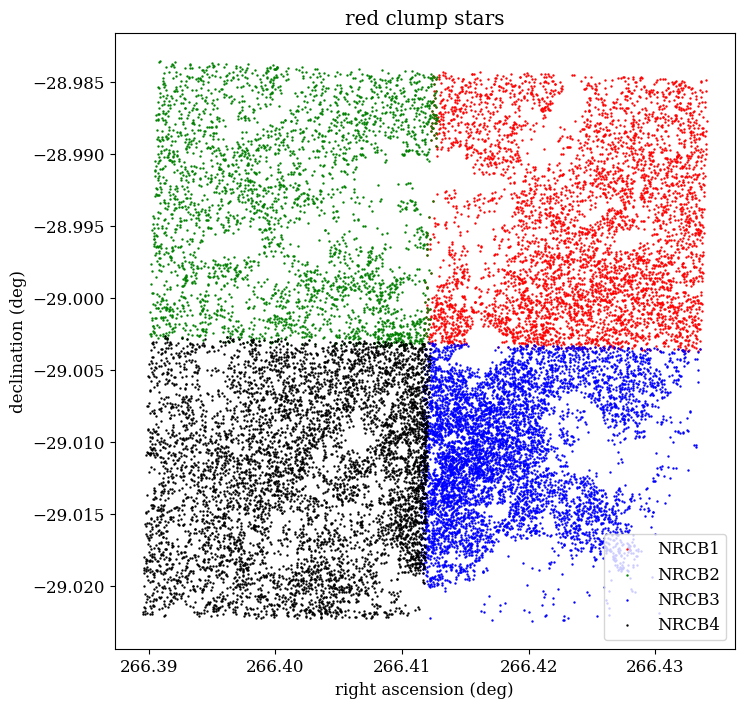

In [8]:
fig, axis = plt.subplots(1, 1, figsize=(8, 8)) 

x1, y1 = nrcb1_['ra'], nrcb1_['dec']
x2, y2 = nrcb2_['ra'], nrcb2_['dec']
x3, y3 = nrcb3_['ra'], nrcb3_['dec']
x4, y4 = nrcb4_['ra'], nrcb4_['dec']

plt.scatter(x1, y1, c='r', s=0.5, label='NRCB1')
plt.scatter(x2, y2, c='g', s=0.5, label='NRCB2')
plt.scatter(x3, y3, c='b', s=0.5, label='NRCB3')
plt.scatter(x4, y4, c='k', s=0.5, label='NRCB4')

plt.legend()
plt.title('red clump stars')
plt.xlabel('right ascension (deg)')
plt.ylabel('declination (deg)')

In [10]:
nrcb1_.to_pickle(NRCB1) 
nrcb2_.to_pickle(NRCB2)
nrcb3_.to_pickle(NRCB3)
nrcb4_.to_pickle(NRCB4)